In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import sys
import os

In [2]:
calib_dir = 'data/data_scene_flow_calib/training/calib_cam_to_cam'
calib_file_paths = os.listdir(calib_dir)
calib_file_paths.sort()
calib_files = []
for calib_file_path in calib_file_paths:
    with open(os.path.join(calib_dir, calib_file_path), 'r') as calib_file:
        calib_files.append(calib_file.readlines())

In [3]:
image_left_dir = 'data/data_scene_flow/training/image_2'
image_right_dir = 'data/data_scene_flow/training/image_3'

image_left_paths = os.listdir(image_left_dir)
image_right_paths = os.listdir(image_right_dir)
image_left_paths.sort()
image_right_paths.sort()

In [4]:
IDX = 50

In [5]:
image_left = cv2.imread(os.path.join(image_left_dir, image_left_paths[IDX*2]))
image_right = cv2.imread(os.path.join(image_right_dir, image_right_paths[IDX*2]))

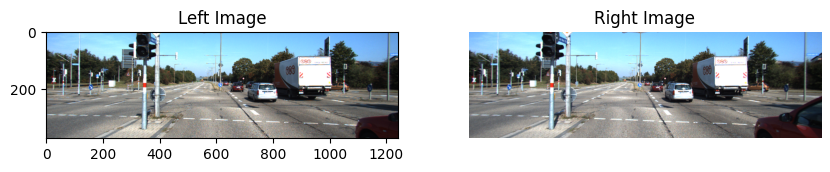

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Left Image')
plt.imshow(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Right Image')
plt.imshow(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

# Extract Camera Calibration

In [7]:
def getCalibrationMatrices(calib_file_path):
    calib_cam_2 = {}
    calib_cam_3 = {}

    with open(calib_file_path, 'r') as f:
        lines = f.readlines()
    

    for line in lines[18:26]:
        key, value = line.split(':')
        key = '_'.join(key.strip().split('_')[:-1])
        calib_cam_2[key] = np.array(value.strip().split(' ')).astype(np.float32)
    calib_cam_2['S'] = calib_cam_2['S'].astype(np.uint32)
    calib_cam_2['K'] = calib_cam_2['K'].reshape(3, 3)
    calib_cam_2['R'] = calib_cam_2['R'].reshape(3, 3)
    calib_cam_2['T'] = calib_cam_2['T'].reshape(3, 1)
    calib_cam_2['S_rect'] = calib_cam_2['S_rect'].astype(np.uint32)
    calib_cam_2['R_rect'] = calib_cam_2['R_rect'].reshape(3, 3)
    calib_cam_2['P_rect'] = calib_cam_2['P_rect'].reshape(3, 4)

    for line in lines[26:34]:
        key, value = line.split(':')
        key = '_'.join(key.strip().split('_')[:-1])
        calib_cam_3[key] = np.array(value.strip().split(' ')).astype(np.float32)
    calib_cam_3['S'] = calib_cam_3['S'].astype(np.uint32)
    calib_cam_3['K'] = calib_cam_3['K'].reshape(3, 3)
    calib_cam_3['R'] = calib_cam_3['R'].reshape(3, 3)
    calib_cam_3['T'] = calib_cam_3['T'].reshape(3, 1)
    calib_cam_3['S_rect'] = calib_cam_3['S_rect'].astype(np.uint32)
    calib_cam_3['R_rect'] = calib_cam_3['R_rect'].reshape(3, 3)
    calib_cam_3['P_rect'] = calib_cam_3['P_rect'].reshape(3, 4)

    return calib_cam_2, calib_cam_3

In [8]:
calib_cam_2, calib_cam_3 = getCalibrationMatrices(os.path.join(calib_dir, calib_file_paths[IDX]))

# Image Rectification

In [9]:
max1x, max1y = cv2.initUndistortRectifyMap(calib_cam_2['K'], calib_cam_2['D'], calib_cam_2['R_rect'], calib_cam_2['P_rect'], calib_cam_2['S_rect'], cv2.CV_32FC1)
max2x, max2y = cv2.initUndistortRectifyMap(calib_cam_3['K'], calib_cam_3['D'], calib_cam_3['R_rect'], calib_cam_3['P_rect'], calib_cam_3['S_rect'], cv2.CV_32FC1)

In [10]:
left_rectified = cv2.remap(image_left, max1x, max1y, cv2.INTER_LINEAR)
right_rectified = cv2.remap(image_right, max2x, max2y, cv2.INTER_LINEAR)

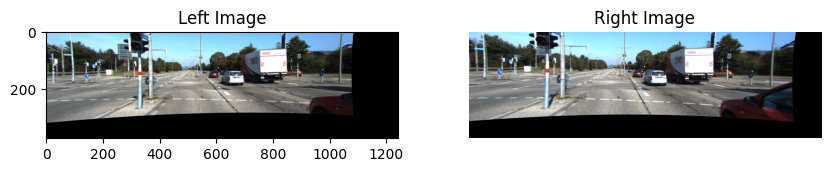

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Left Image')
plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Right Image')
plt.imshow(cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

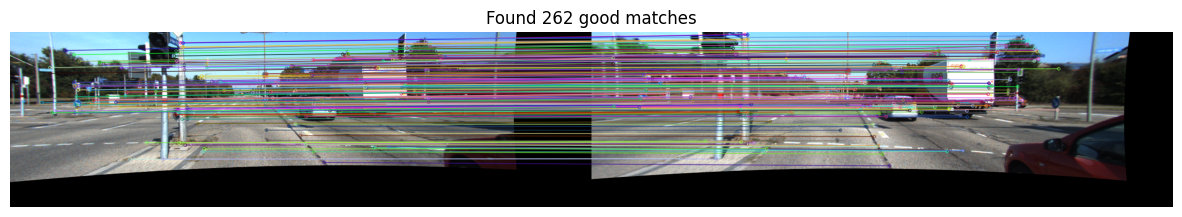

In [12]:
def find_and_visualize_matches(left_rectified, right_rectified, nfeatures=100, max_points=50):
    # Convert to grayscale
    gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector with reduced features
    sift = cv2.SIFT_create(nfeatures=nfeatures)  # Reduce number of features

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray_left, None)
    kp2, des2 = sift.detectAndCompute(gray_right, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Filter good matches using stricter Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:  # Stricter ratio
            good_matches.append(m)

    # Sort matches by distance and take top N
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    good_matches = good_matches[:max_points]

    # Draw matches
    matched_img = cv2.drawMatches(
        left_rectified, kp1,
        right_rectified, kp2,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Found {len(good_matches)} good matches')
    plt.axis('off')
    plt.show()

    return kp1, kp2, good_matches

# Call with reduced number of points
kp1, kp2, good_matches = find_and_visualize_matches(left_rectified, right_rectified, 
                                                    max_points=1000, nfeatures=1000)

# Disparity map

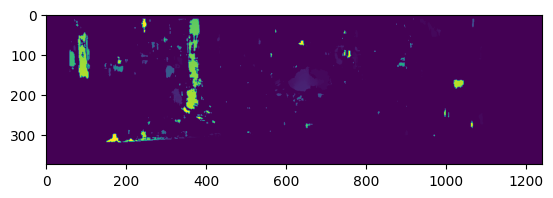

In [13]:
stereo = cv2.StereoBM.create(numDisparities=16*3, blockSize=25)
disparity = stereo.compute(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY), cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY))
plt.imshow(disparity)
plt.show()

In [14]:
# stereo = cv2.StereoSGBM_create(
#     minDisparity=0,
#     numDisparities=16*7,  # Must be divisible by 16
#     blockSize=7,
#     P1=8 * 3 * 7 ** 2,
#     P2=32 * 3 * 7 ** 2,
#     disp12MaxDiff=1,
#     uniquenessRatio=10,
#     speckleWindowSize=50,
#     speckleRange=32,
#     preFilterCap=63,
#     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
# )

# # Tính disparity map từ ảnh đã làm phẳng
# disparity = stereo.compute(left_rectified, right_rectified).astype(np.float32) / 16.0
# plt.imshow((disparity - disparity.min()) / (disparity.max() - disparity.min()))
# plt.colorbar()
# plt.show()

# Depth map

In [15]:
T = calib_cam_2['T'] - calib_cam_3['T']

baseline = np.linalg.norm(T)
print('Baseline:', baseline)

Baseline: 0.5327547


In [16]:
focal_length = (calib_cam_2['K'][0][0] + calib_cam_2['K'][1][1]) / 2
print('Focal Length:', focal_length)

Focal Length: 958.3580322265625


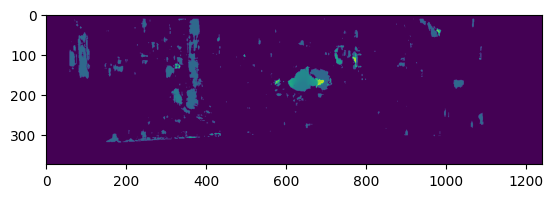

In [17]:
# Tính depth map
depth_map = np.zeros(disparity.shape, dtype=np.float32)
depth_map[disparity != 0] = (focal_length * focal_length) / disparity[disparity != 0]

# Hiển thị depth map
plt.imshow(depth_map)
plt.show()

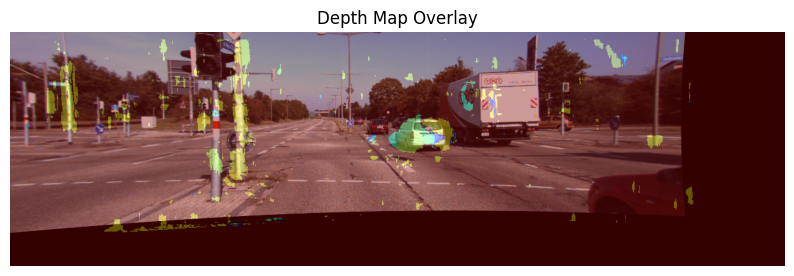

In [18]:
# Normalize the depth map for visualization
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

# Convert the normalized depth map to an 8-bit image
depth_map_normalized = np.uint8(depth_map_normalized)

# Apply a color map to the normalized depth map
depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

# Overlay the depth map on the original image
overlay = cv2.addWeighted(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB), 0.6, depth_map_colored, 0.4, 0)

# Display the result
plt.figure(figsize=(10, 5))
plt.title('Depth Map Overlay')
plt.imshow(overlay)
plt.axis('off')
plt.show()

In [27]:
def nothing(x):
    pass

cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
cv2.resizeWindow('disp',600,600)
 
cv2.createTrackbar('numDisparities','disp',1,17,nothing)
cv2.createTrackbar('blockSize','disp',5,50,nothing)
cv2.createTrackbar('preFilterType','disp',1,1,nothing)
cv2.createTrackbar('preFilterSize','disp',2,25,nothing)
cv2.createTrackbar('preFilterCap','disp',5,62,nothing)
cv2.createTrackbar('textureThreshold','disp',10,100,nothing)
cv2.createTrackbar('uniquenessRatio','disp',15,100,nothing)
cv2.createTrackbar('speckleRange','disp',0,100,nothing)
cv2.createTrackbar('speckleWindowSize','disp',3,25,nothing)
cv2.createTrackbar('disp12MaxDiff','disp',5,25,nothing)
cv2.createTrackbar('minDisparity','disp',5,25,nothing)

stereo = cv2.StereoBM_create()

while True:
    left_gray = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

    left_nice = cv2.remap(left_gray, max1x, max1y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    right_nice = cv2.remap(right_gray, max2x, max2y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    # Updating the parameters based on the trackbar positions
    numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
    blockSize = cv2.getTrackbarPos('blockSize','disp')*2 + 5
    preFilterType = cv2.getTrackbarPos('preFilterType','disp')
    preFilterSize = cv2.getTrackbarPos('preFilterSize','disp')*2 + 5
    preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
    textureThreshold = cv2.getTrackbarPos('textureThreshold','disp')
    uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
    speckleRange = cv2.getTrackbarPos('speckleRange','disp')
    speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')*2
    disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff','disp')
    minDisparity = cv2.getTrackbarPos('minDisparity','disp')

    # Setting the updated parameters before computing disparity map
    stereo.setNumDisparities(numDisparities)
    stereo.setBlockSize(blockSize)
    stereo.setPreFilterType(preFilterType)
    stereo.setPreFilterSize(preFilterSize)
    stereo.setPreFilterCap(preFilterCap)
    stereo.setTextureThreshold(textureThreshold)
    stereo.setUniquenessRatio(uniquenessRatio)
    stereo.setSpeckleRange(speckleRange)
    stereo.setSpeckleWindowSize(speckleWindowSize)
    stereo.setDisp12MaxDiff(disp12MaxDiff)
    stereo.setMinDisparity(minDisparity)
    
    # Calculating disparity using the StereoBM algorithm
    try:
        disparity = stereo.compute(left_nice, right_nice)
    except:
        break
    # NOTE: Code returns a 16bit signed single channel image,
    # CV_16S containing a disparity map scaled by 16. Hence it 
    # is essential to convert it to CV_32F and scale it down 16 times.
    
    # Converting to float32 
    disparity = disparity.astype(np.float32)
    
    # Scaling down the disparity values and normalizing them 
    disparity = (disparity/16.0 - minDisparity)/numDisparities
    
    # Displaying the disparity map
    # cv2.imshow("disp",disparity)

    depth_map = np.zeros(disparity.shape, dtype=np.float32)
    depth_map[disparity != 0] = (focal_length * focal_length) / disparity[disparity != 0]

    # Hiển thị depth map
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)
    depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB), 0.6, depth_map_colored, 0.4, 0)
    # cv2.imshow("Depth Map Overlay", overlay)
    cv2.imshow("disp", overlay)
    
    
    # Close window using esc key
    if cv2.waitKey(1) == 27:
        break
cv2.destroyAllWindows()